In [6]:
""" The model code from this file is adapted from the following:
https://github.com/pietrobarbiero/pytorch_explain/blob/master/experiments/elens/mnist.py

Credit to Pietro Barbiero for the original code."""

' The model code from this file is adapted from the following:\nhttps://github.com/pietrobarbiero/pytorch_explain/blob/master/experiments/elens/mnist.py\n\nCredit to Pietro Barbiero for the original code.'

In [7]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.functional import one_hot
import imblearn
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.model_selection import StratifiedKFold, train_test_split
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
import os
from torch_explain.models.explainer import Explainer
import time
from torchmetrics.functional import precision_recall
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.linear_model import LassoCV
from torch_explain.logic.metrics import formula_consistency
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from func_timeout import func_set_timeout, func_timeout, FunctionTimedOut


In [8]:
files = os.listdir("./categorisedData/")


datasets = {file : pd.read_csv("./categorisedData/" + file).set_index('PatientID') for file in files}


print(files)

print(len(datasets))

results_dict = {}


['clusteredData.csv', 'expertLabelledData.csv', 'metricExtractedData.csv', 'staticData.csv']
4


In [9]:
@func_set_timeout(60)
def explain_with_timeout(model, val_data, train_data, test_data, topk_expl, concepts):

    return model.explain_class(val_dataloaders=val_data, train_dataloaders=train_data, test_dataloaders=test_data, topk_explanations=topk_expl, concept_names=concepts)

In [88]:


for file in files[-1:]:

    print(f"Training {file}\n")

    data = datasets[file]

    if file == "staticData.csv":
        targetName = "deathperiod"
    else:
        targetName = "Mortality14Days"

    targetSeries = data[targetName]
    data = data.drop(columns=[targetName])


    dataTensor = torch.FloatTensor(data.to_numpy())
    targetTensor = one_hot(torch.tensor(targetSeries.values).to(torch.long)).to(torch.float)


    dataset = TensorDataset(dataTensor, targetTensor)
    train_size = int(0.8 * len(dataset))

    val_size = (len(dataset) - train_size) // 2
    test_size = len(dataset) - train_size - val_size

    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=train_size)
    val_loader = DataLoader(val_data, batch_size=val_size)
    test_loader = DataLoader(test_data, batch_size=test_size)



    n_concepts = next(iter(train_loader))[0].shape[1]
    # self.n_concepts = n_concepts


    n_classes = targetTensor.shape[1]
    # self.n_classes = n_classes

    print("Training on {} classes".format(n_classes))

    print("Num concepts: {}".format(n_concepts))
    print("Num classes: {}".format(n_classes))

    base_dir = f'./results/mimicLEN/explainer'
    os.makedirs(base_dir, exist_ok=True)

    seed_everything(40)

    n_splits = 5

    # self.n_splits = n_splits

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # self.skf = skf

    results_list = []
    feature_selection = []
    explanations = {i: [] for i in range(n_classes)}

    explanations_list = []
    splitResults_list = []
    scores_list = []

    x = dataTensor
    y = targetTensor


    for split, (trainval_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(),
                                                            y.argmax(dim=1).cpu().detach().numpy())):
        

        print(f'Split [{split + 1}/{n_splits}]')
        x_trainval, x_test = torch.FloatTensor(x[trainval_index]), torch.FloatTensor(x[test_index])
        y_trainval, y_test = torch.FloatTensor(y[trainval_index]), torch.FloatTensor(y[test_index])
        x_train_unbalanced, x_val, y_train_unbalanced, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=42)
        print(f'{len(y_train_unbalanced)}/{len(y_val)}/{len(y_test)}')


        # Rebalancing training set
        obj = imblearn.over_sampling.SMOTEN(random_state=0, n_jobs=4)

        print(sorted(Counter(torch.argmax(y_train_unbalanced, axis=1).numpy()).items()))

        x_train, y_train = obj.fit_resample(x_train_unbalanced.numpy(), torch.argmax(y_train_unbalanced, axis=1).numpy())

        print(sorted(Counter(y_train).items()))

        y_train = one_hot(torch.tensor(y_train).to(torch.long)).to(torch.float)
        x_train = torch.FloatTensor(x_train)

        train_data = TensorDataset(x_train, y_train)
        val_data = TensorDataset(x_val, y_val)
        test_data = TensorDataset(x_test, y_test)
        train_loader = DataLoader(train_data, batch_size=train_size)
        val_loader = DataLoader(val_data, batch_size=val_size)
        test_loader = DataLoader(test_data, batch_size=test_size)

        checkpoint_callback = ModelCheckpoint(dirpath=base_dir, monitor='val_loss', save_top_k=1)

        # Constructs the way that the model will be trained
        trainer = Trainer(max_epochs=200, gpus=1, auto_lr_find=True, deterministic=True,
                        check_val_every_n_epoch=1, default_root_dir=base_dir,
                        weights_save_path=base_dir, callbacks=[checkpoint_callback], enable_progress_bar=False)

        # This is the model itself, which is extended from pytorch_lightning
        model = Explainer(n_concepts=n_concepts, n_classes=n_classes, l1=1e-3, lr=0.01,
                        explainer_hidden=[20], temperature=0.7)


        start = time.time()
        trainer.fit(model, train_loader, val_loader)
        # print(f"Gamma: {model.model[0].concept_mask}")
        model.freeze()
        print("\nTesting...\n")
        model_results = trainer.test(model, test_dataloaders=test_loader)
        print("\nExplaining\n")
        
        try:

            results, f = explain_with_timeout(model, val_data=val_loader, train_data=train_loader, test_data=test_loader,
                                        topk_expl=10,
                                        concepts=data.columns)
        except FunctionTimedOut:
            print("Explanation timed out, skipping...")
            # explanations_list.append(None)
            # results_list.append(None)
            continue

        end = time.time()
        # explanations_list.append(f)

        print(f"Explaining time: {end - start}")
        results['model_accuracy'] = model_results[0]['test_acc']
        results['extraction_time'] = end - start

        results_list.append(results)
        extracted_concepts = []
        all_concepts = model.model[0].concept_mask[0] > 0.5
        common_concepts = model.model[0].concept_mask[0] > 0.5
        for j in range(n_classes):
            # print(f[j]['explanation'])
            n_used_concepts = sum(model.model[0].concept_mask[j] > 0.5)
            print(f"Number of features that impact on target {j}: {n_used_concepts}")
            print(f"Explanation for target {j}: {f[j]['explanation']}")
            print(f"Explanation accuracy: {f[j]['explanation_accuracy']}")
            explanations[j].append(f[j]['explanation'])
            extracted_concepts.append(n_used_concepts)
            all_concepts += model.model[0].concept_mask[j] > 0.5
            common_concepts *= model.model[0].concept_mask[j] > 0.5

        explanations_list.append(explanations)

        results['extracted_concepts'] = np.mean(extracted_concepts)
        results['common_concepts_ratio'] = sum(common_concepts) / sum(all_concepts)

        # Precision, Recall, F1
        # print(x_test)
        print("Type:", type(x_test))
        y_pred = torch.argmax(model(x_test), axis=1)
        # print("Predictions:", y_pred)
        y_test_argmax = torch.argmax(y_test, axis=1)
        # print("Actual:", y_test_argmax)

        scores = [f1_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'), recall_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'), precision_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro')]

        print(f"{file} split {split+1} scores: {scores}")

        scores_list.append(scores)


        prec_rec = precision_recall(y_pred, y_test_argmax, num_classes = n_classes)

        print(prec_rec)

        # compare against standard feature selection
        i_mutual_info = mutual_info_classif(x_trainval, y_trainval[:, 1])
        i_chi2 = chi2(x_trainval, y_trainval[:, 1])[0]
        i_chi2[np.isnan(i_chi2)] = 0
        lasso = LassoCV(cv=5, random_state=0).fit(x_trainval, y_trainval[:, 1])
        i_lasso = np.abs(lasso.coef_)
        i_mu = model.model[0].concept_mask[1]
        # print(model.model[0].concept_mask)
        df = pd.DataFrame(np.hstack([
            i_mu.numpy(),
            # i_mutual_info / np.max(i_mutual_info),
            # i_chi2 / np.max(i_chi2),
            # i_lasso / np.max(i_lasso),
        ]).T, columns=['feature importance'])
        df['method'] = 'explainer'
        # df.iloc[90:, 1] = 'MI'
        # df.iloc[180:, 1] = 'CHI2'
        # df.iloc[270:, 1] = 'Lasso'
        df['feature'] = np.hstack([np.arange(0, n_concepts)])
        feature_selection.append(df)

        splitResults = [results['model_accuracy'], results['extraction_time'], *scores, f]

        splitResults_list.append(splitResults)


    results_dict[file] = splitResults_list

# results_dict[file] = [results['model_accuracy'], results['extraction_time'], *scores, f]
# self.feature_selection = feature_selection
# # print(self.feature_selection)

# self.df = df
# self.explanations = explanations
# self.results_list = results_list
# print(results_dict)

Global seed set to 40


Training staticData.csv

Training on 2 classes
Num concepts: 52
Num classes: 2
Split [1/5]
3367/842/1053
[(0, 2928), (1, 439)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.1 K 
-------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 2928), (1, 2928)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6514719724655151, 'test_acc_epoch': 0.6514719724655151}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 26.215768337249756
Number of features that impact on target 0: 4
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 12
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
staticData.csv split 1 scores: [0.5055800415800416, 0.5525250176406441, 0.5268177352001965]
(tensor(0.6515), tensor(0.6515))
Split [2/5]
3367/842/1053
[(0, 2946), (1, 421)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.1 K 
-------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 2946), (1, 2946)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6372269988059998, 'test_acc_epoch': 0.6372269988059998}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 31.386986017227173
Number of features that impact on target 0: 1
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 10
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
staticData.csv split 2 scores: [0.48612360239560126, 0.5224276733594202, 0.5114339675090548]
(tensor(0.6372), tensor(0.6372))
Split [3/5]
3368/842/1052
[(0, 2935), (1, 433)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.1 K 
-------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


[(0, 2935), (1, 2935)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (t


Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6511406898498535, 'test_acc_epoch': 0.6511406898498535}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 32.28672409057617
Number of features that impact on target 0: 10
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 9
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
staticData.csv split 3 scores: [0.5152469379939859, 0.5756411809846924, 0.5375883108542068]
(tensor(0.6511), tensor(0.6511))
Split [4/5]
3368/842/1052
[(0, 2933), (1, 435)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.1 K 
-------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


[(0, 2933), (1, 2933)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (t


Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6844106316566467, 'test_acc_epoch': 0.6844106316566467}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 30.939325094223022
Number of features that impact on target 0: 10
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 11
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
staticData.csv split 4 scores: [0.519745671352826, 0.5568237812512622, 0.5311190837465881]
(tensor(0.6844), tensor(0.6844))
Split [5/5]
3368/842/1052
[(0, 2931), (1, 437)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.1 K 
-------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 2931), (1, 2931)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6321292519569397, 'test_acc_epoch': 0.6321292519569397}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 29.042405366897583
Number of features that impact on target 0: 13
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 6
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
staticData.csv split 5 scores: [0.483003356279977, 0.5195222193680966, 0.5098841297129457]
(tensor(0.6321), tensor(0.6321))


In [81]:
results_dict.keys()

dict_keys(['clusteredData.csv', 'expertLabelledData.csv', 'metricExtractedData.csv', 'staticData.csv'])

In [87]:
kFoldMeans = []

bestExplanationsDict = {f:[0,0] for f in results_dict.keys()}

# print(bestExplanationsDict)

for x in results_dict:

    cols = ['file']

    cols.extend(['model_accuracy', 'extraction_time', 'f1', 'recall', 'precision'])

    for idx, d in enumerate(results_dict[x][0][5]):
        cols.extend([str(x) + "_" + str(idx) for x in d])

    # print(cols)

    rows = []

    for split in results_dict[x]:


        if split[5][1]['explanation_accuracy'] > bestExplanationsDict[x][0]:
            bestExplanationsDict[x] = [split[2], split[5]]

        row = [x]

        row.extend(split[:5])


        for d in split[5]:

            row.extend(d.values())

        rows.append(row)


    df = pd.DataFrame(columns=cols, data=rows)

    df = df.set_index('file')

    combinedCols = list(df.describe().columns)

    # print(combinedCols)

    row = [x]
    row.extend(df.describe().loc['mean'].values)

    print(row)
    kFoldMeans.append(row)

# print(kFoldMeans)



kFoldMeansCols = list(df.describe().columns)

combinedCols.insert(0, "file")


# print(kFoldMeansCols)

totalMeans = pd.DataFrame(columns=combinedCols, data=kFoldMeans)

totalMeans = totalMeans.set_index('file')

display(totalMeans)

print("Best explanations on minority class:\n")
for i in bestExplanationsDict:
    print(f"{i}:\n")
    print(bestExplanationsDict[i][1])

['clusteredData.csv', 0.9374563694000244, 30.03034453392029, 0.5437334068773809, 0.55519766661071, 0.5359446419947392, 0.0, 0.556394076975318, 0.9395397033158812, 5.2, 1.0, 0.4634583764902199, 0.827732329842932, 5.6]
['expertLabelledData.csv', 0.9290200074513754, 32.973791201909386, 0.5037782034908472, 0.5012202124605225, 0.5119497870639423, 0.0, 0.48904002160304677, 0.9689544411668306, 4.333333333333333, 1.0, 0.45182303925839856, 0.7868436578171091, 5.666666666666667]
['metricExtractedData.csv', 0.9072044014930725, 28.296786546707153, 0.5358074926656283, 0.5532524760785631, 0.5351275242774085, 0.0, 0.4856885102806555, 0.7945298865619546, 5.4, 1.0, 0.37032015044677974, 0.6582678883071553, 3.6]
['staticData.csv', 0.651275908946991, 27.57542781829834, 0.5019399219204864, 0.5453879745208232, 0.5233686454045984, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


,model_accuracy,extraction_time,f1,recall,precision,target_class_0,explanation_accuracy_0,explanation_fidelity_0,explanation_complexity_0,target_class_1,explanation_accuracy_1,explanation_fidelity_1,explanation_complexity_1
file,,,,,,,,,,,,,
clusteredData.csv,0.937456,30.030345,0.543733,0.555198,0.535945,0.0,0.556394,0.939540,5.200000,1.0,0.463458,0.827732,5.600000
expertLabelledData.csv,0.929020,32.973791,0.503778,0.501220,0.511950,0.0,0.489040,0.968954,4.333333,1.0,0.451823,0.786844,5.666667
metricExtractedData.csv,0.907204,28.296787,0.535807,0.553252,0.535128,0.0,0.485689,0.794530,5.400000,1.0,0.370320,0.658268,3.600000
staticData.csv,0.651276,27.575428,0.501940,0.545388,0.523369,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000


Best explanations on minority class:

clusteredData.csv:

[{'target_class': 0, 'explanation': 'Arterial PaCO2_StdDev_medium | Arterial PaO2_StdDev_medium | ~Arterial PaO2_StdDev_medium', 'explanation_accuracy': 0.4907161803713528, 'explanation_fidelity': 0.96875, 'explanation_complexity': 3}, {'target_class': 1, 'explanation': '~Arterial BP [Systolic]_StdDev_medium & ~Arterial PaCO2_Mean_medium & ~Arterial PaO2_StdDev_low & ~Arterial PaO2_StdDev_very_high & ~Hemoglobin_StdDev_low & ~SVR_StdDev_low & ~SVRI_Mean_medium', 'explanation_accuracy': 0.49118157726400435, 'explanation_fidelity': 0.8854166666666666, 'explanation_complexity': 7}]
expertLabelledData.csv:

[{'target_class': 0, 'explanation': 'Arterial_PaCO2_low | SVRI_Min_low | ~Arterial_PaCO2_low', 'explanation_accuracy': 0.48863636363636365, 'explanation_fidelity': 0.9777777777777777, 'explanation_complexity': 3}, {'target_class': 1, 'explanation': 'Daily_Weight_low & SVI_medium & ~Arterial_pH_Max_high & ~INR_low & ~Ionized_Calci

In [8]:
for x in results_dict:

    modelMetrics = [x.values() for x in results_dict[x][0] if x is not None]

    modelMetricsKeys = results_dict[x][0][0].keys()

    df = pd.DataFrame(columns=modelMetricsKeys, data=modelMetrics)

    df[['F1', 'Recall', 'Precision']] = results_dict[x][1]

    df['common_concepts_ratio'] = df['common_concepts_ratio'].apply(lambda x: x.numpy())

    print(x + " results:")
    display(df)
    display(df.describe().T)
    display(df.describe().loc['mean'])

clusteredData.csv results:


,explanation_accuracy,explanation_fidelity,explanation_complexity,model_accuracy,extraction_time,extracted_concepts,common_concepts_ratio,F1,Recall,Precision
0,0.528486,0.885417,4.5,0.968750,53.940723,10.5,0.000000,0.691979,0.661290,0.739362
1,0.406992,0.718750,1.5,0.947917,40.270676,6.5,0.000000,0.486631,0.489247,0.484043
2,0.508939,0.802083,1.0,0.968750,48.979285,9.5,0.055556,0.691979,0.661290,0.739362
3,0.545987,0.828125,4.0,0.947917,33.568216,7.5,0.000000,0.629344,0.650538,0.614130
4,0.605404,0.760417,2.0,0.916667,49.157717,8.5,0.000000,0.478261,0.478261,0.478261
5,0.448253,0.812500,4.0,0.937500,14.371897,5.0,0.000000,0.483871,0.489130,0.478723
6,0.517642,0.857895,4.0,0.978947,14.908269,5.0,0.000000,0.744624,0.666667,0.989362


,count,mean,std,min,25%,50%,75%,max
explanation_accuracy,7.0,0.508815,0.064823,0.406992,0.478596,0.517642,0.537236,0.605404
explanation_fidelity,7.0,0.809312,0.056511,0.718750,0.781250,0.812500,0.843010,0.885417
explanation_complexity,7.0,3.000000,1.443376,1.000000,1.750000,4.000000,4.000000,4.500000
model_accuracy,7.0,0.952350,0.021519,0.916667,0.942708,0.947917,0.968750,0.978947
extraction_time,7.0,36.456683,16.323731,14.371897,24.238243,40.270676,49.068501,53.940723
extracted_concepts,7.0,7.500000,2.140872,5.000000,5.750000,7.500000,9.000000,10.500000
common_concepts_ratio,7.0,0.007937,0.020998,0.000000,0.000000,0.000000,0.000000,0.055556
F1,7.0,0.600955,0.115362,0.478261,0.485251,0.629344,0.691979,0.744624
Recall,7.0,0.585203,0.093414,0.478261,0.489189,0.650538,0.661290,0.666667
Precision,7.0,0.646177,0.190916,0.478261,0.481383,0.614130,0.739362,0.989362


explanation_accuracy       0.508815
explanation_fidelity       0.809312
explanation_complexity     3.000000
model_accuracy             0.952350
extraction_time           36.456683
extracted_concepts         7.500000
common_concepts_ratio      0.007937
F1                         0.600955
Recall                     0.585203
Precision                  0.646177
Name: mean, dtype: float64

clusteredData.csv
['Arterial BP [Diastolic]_Mean_medium | CVP_StdDev_very_low | Ionized Calcium_Mean_high | ~Arterial BP [Systolic]_Mean_very_low', 'Arterial BP [Systolic]_StdDev_very_low | ~CVP_StdDev_high', '~CVP_Mean_very_high', 'Arterial PaO2_StdDev_medium | ~CVP_StdDev_high | (Arterial BP [Diastolic]_Mean_low & ~SVR_Mean_high)', '~CVP_Mean_very_high', 'Arterial PaCO2_Mean_high | Hemoglobin_StdDev_very_high | ~CVP_StdDev_high', 'Arterial BP [Systolic]_Mean_medium | SVRI_Mean_very_low | ~CVP_Mean_very_high']
['CVP_Mean_very_high & ~Arterial BP Mean_Mean_low & ~Arterial BP [Diastolic]_StdDev_medium & ~Arterial pH_Mean_very_high & ~SVRI_StdDev_very_high', '~Arterial pH_StdDev_medium', 'Ionized Calcium_Mean_high', '~Arterial BP Mean_Mean_high & ~Arterial pH_StdDev_medium & ~Arterial pH_Mean_very_high & ~Ionized Calcium_StdDev_low', '~Ionized Calcium_Mean_high & ~Platelets_StdDev_low & ~SVRI_StdDev_low', '~Arterial PaCO2_StdDev_medium & ~Hemoglobin_Mean_medium & ~Hemoglobin_Mean_very_lo

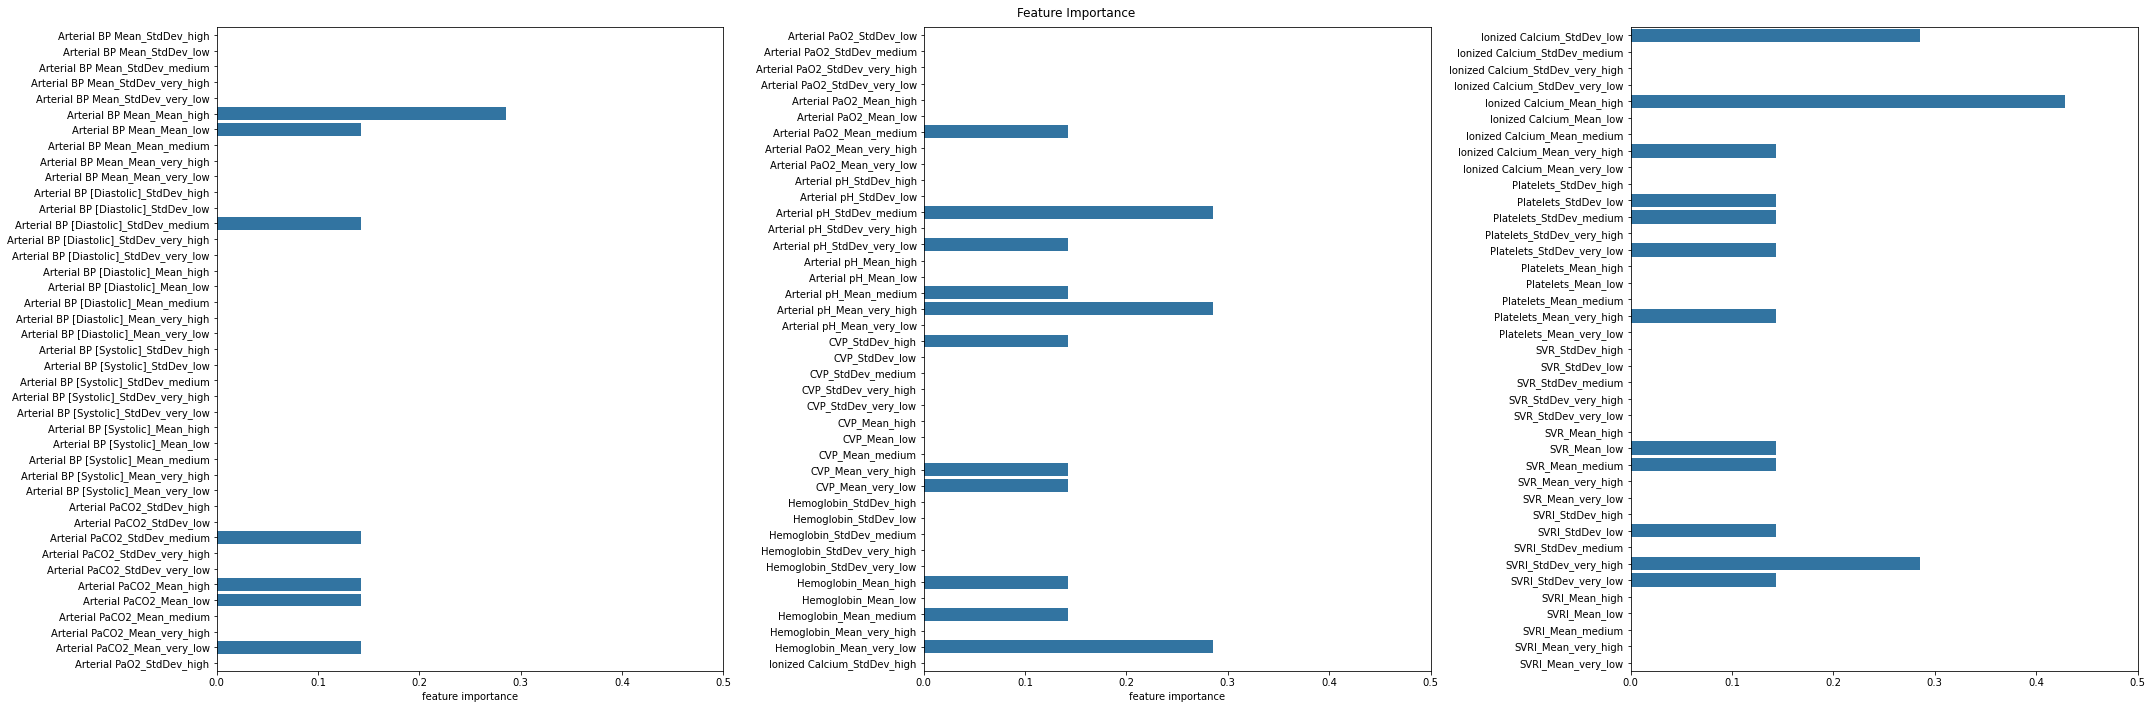

Split [1/10]
Split [2/10]
Split [3/10]
Split [4/10]
Split [5/10]
Split [6/10]
Split [7/10]
Split [8/10]
Split [9/10]
Split [10/10]
Random forest scores: 0.9624671052631578 (+/- 0.0050636173857774225)
Decision tree scores: 0.9395394736842105 (+/- 0.018473075559357465)
Mu net scores (model): 0.9523496287209647 (+/- 0.021519249008089818)
Mu net scores (exp): 0.508814625950885 (+/- 0.06482256898487601)


In [11]:
for file in results_dict:
    print(file)

    feature_selection = results_dict[file][2]
    explanations = results_dict[file][3][0]

    base_dir = f'./results/mimicLEN/explainer'

    consistencies = []
    # print(explanations)
    for j in range(n_classes):
        if explanations[j][0] is None:
            continue
        consistencies.append(formula_consistency(explanations[j]))
    explanation_consistency = np.mean(consistencies)

    concat_feature_selection = pd.concat(feature_selection, axis=0)

    # print("Feature selection: ", feature_selection)

    f1 = concat_feature_selection[concat_feature_selection['feature'] <= n_concepts//3]
    f2 = concat_feature_selection[(concat_feature_selection['feature'] > n_concepts//3) & (concat_feature_selection['feature'] <= (n_concepts*2)//3)]
    f3 = concat_feature_selection[concat_feature_selection['feature'] > (n_concepts*2)//3]

    sets = [f1, f2, f3]

    fig = plt.figure(figsize=[30, 10])
    fig.suptitle("Feature Importance")

    # print(sets)

    for i in range(len(sets)):
        f = sets[i]

        plt.subplot(1, 3, i+1)
        # print(f.iloc[:, 0][f.iloc[:, 0] != False])

        # sums = [featureDF['feature importance'].sum() for _, featureDF in f.groupby('feature')]
        # print(len(sums))
        # print(len(f['feature']))

        ax = sns.barplot(y=data.columns[f['feature']], x=f.iloc[:,0], orient='h', hue=f['method'], errwidth=0.5, ci=None)
                        # hue=f['method'],  , errcolor='k')
        ax.set(xlim=(0,0.5))
        ax.set_title("")
        ax.get_legend().remove()

    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'barplot_mimic.png'))
    plt.savefig(os.path.join(base_dir, 'barplot_mimic.pdf'))
    plt.show()


    results_list = [x for x in results_list if x is not None]

    results_df = pd.DataFrame(results_list)
    results_df['explanation_consistency'] = explanation_consistency
    results_df.to_csv(os.path.join(base_dir, 'results_aware_mimic.csv'))
    results_df


results_df.mean()

results_df.sem()

x = dataTensor
y = targetTensor

dt_scores, rf_scores = [], []
for split, (trainval_index, test_index) in enumerate(
        skf.split(x.cpu().detach().numpy(), y.argmax(dim=1).cpu().detach().numpy())):
    print(f'Split [{split + 1}/{n_splits}]')
    x_trainval, x_test = x[trainval_index], x[test_index]
    y_trainval, y_test = y[trainval_index].argmax(dim=1), y[test_index].argmax(dim=1)

    dt_model = DecisionTreeClassifier(max_depth=5, random_state=split)
    dt_model.fit(x_trainval, y_trainval)
    dt_scores.append(dt_model.score(x_test, y_test))

    rf_model = RandomForestClassifier(random_state=split)
    rf_model.fit(x_trainval, y_trainval)
    rf_scores.append(rf_model.score(x_test, y_test))

print(f'Random forest scores: {np.mean(rf_scores)} (+/- {np.std(rf_scores)})')
print(f'Decision tree scores: {np.mean(dt_scores)} (+/- {np.std(dt_scores)})')
print(f'Mu net scores (model): {results_df["model_accuracy"].mean()} (+/- {results_df["model_accuracy"].std()})')
print(f'Mu net scores (exp): {results_df["explanation_accuracy"].mean()} (+/- {results_df["explanation_accuracy"].std()})')


In [101]:
for file in files:

    
    print(f"Training {file}\n")

    data = datasets[file]

    if file == "staticData.csv":
        targetName = "deathperiod"
    else:
        targetName = "Mortality14Days"

    targetSeries = data[targetName]
    data = data.drop(columns=[targetName])


    dataTensor = torch.FloatTensor(data.to_numpy())
    targetTensor = one_hot(torch.tensor(targetSeries.values).to(torch.long)).to(torch.float)


    # dataset = TensorDataset(dataTensor, targetTensor)
    train_size = int(0.8 * len(dataset))

    # val_size = (len(dataset) - train_size) // 2
    test_size = len(dataset) - train_size - val_size

    # train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    # train_loader = DataLoader(train_data, batch_size=train_size)
    # val_loader = DataLoader(val_data, batch_size=val_size)
    # test_loader = DataLoader(test_data, batch_size=test_size)



    n_concepts = dataTensor.shape[1]
    # self.n_concepts = n_concepts


    n_classes = targetTensor.shape[1]
    # self.n_classes = n_classes

    print("Training on {} classes".format(n_classes))

    print("Num concepts: {}".format(n_concepts))
    print("Num classes: {}".format(n_classes))

    base_dir = f'./results/mimicLEN/explainer'
    os.makedirs(base_dir, exist_ok=True)

    seed_everything(40)

    n_splits = 10

    # self.n_splits = n_splits

    # skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # self.skf = skf

    results_list = []
    feature_selection = []
    explanations = {i: [] for i in range(n_classes)}

    scores_list = []

    # x = dataTensor
    # y = targetTensor


        

    # x_trainval, x_test = torch.FloatTensor(x[trainval_index]), torch.FloatTensor(x[test_index])
    # y_trainval, y_test = torch.FloatTensor(y[trainval_index]), torch.FloatTensor(y[test_index])
    x_train_unbalanced, x_test, y_train_unbalanced, y_test = train_test_split(dataTensor, targetTensor, test_size=0.2, random_state=42)
    print(f'{len(y_train_unbalanced)}/{len(y_val)}/{len(y_test)}')


    # Rebalancing training set
    obj = imblearn.over_sampling.SMOTEN(random_state=0, n_jobs=4)

    print(sorted(Counter(torch.argmax(y_train_unbalanced, axis=1).numpy()).items()))

    x_train, y_train = obj.fit_resample(x_train_unbalanced.numpy(), torch.argmax(y_train_unbalanced, axis=1).numpy())

    print(sorted(Counter(y_train).items()))

    y_train = one_hot(torch.tensor(y_train).to(torch.long)).to(torch.float)
    x_train = torch.FloatTensor(x_train)

    train_data = TensorDataset(x_train, y_train)
    # val_data = TensorDataset(x_val, y_val)
    test_data = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_data, batch_size=train_size)
    # val_loader = DataLoader(val_data, batch_size=val_size)
    test_loader = DataLoader(test_data, batch_size=test_size)

    checkpoint_callback = ModelCheckpoint(dirpath=base_dir, monitor='val_loss', save_top_k=1)

    # Constructs the way that the model will be trained
    trainer = Trainer(max_epochs=200, gpus=1, auto_lr_find=True, deterministic=True,
                    check_val_every_n_epoch=1, default_root_dir=base_dir,
                    weights_save_path=base_dir, callbacks=[checkpoint_callback], enable_progress_bar=False)

    # This is the model itself, which is extended from pytorch_lightning
    model = Explainer(n_concepts=n_concepts, n_classes=n_classes, l1=1e-3, lr=0.01,
                    explainer_hidden=[20], temperature=0.7)


    start = time.time()
    trainer.fit(model, train_loader, test_loader)
    # print(f"Gamma: {model.model[0].concept_mask}")
    model.freeze()
    print("\nTesting...\n")
    model_results = trainer.test(model, test_dataloaders=test_loader)
    print("\nExplaining\n")
    
    try:

        results, f = explain_with_timeout(model, val_data=test_loader, train_data=train_loader, test_data=test_loader,
                                    topk_expl=10,
                                    concepts=data.columns)
    except FunctionTimedOut:
        print("Explanation timed out, skipping...")
        results_list.append(None)
        continue

    end = time.time()

    print(f"Explaining time: {end - start}")
    results['model_accuracy'] = model_results[0]['test_acc']
    results['extraction_time'] = end - start

    # results_list.append(results)
    extracted_concepts = []
    all_concepts = model.model[0].concept_mask[0] > 0.5
    common_concepts = model.model[0].concept_mask[0] > 0.5
    for j in range(n_classes):
        # print(f[j]['explanation'])
        n_used_concepts = sum(model.model[0].concept_mask[j] > 0.5)
        print(f"Number of features that impact on target {j}: {n_used_concepts}")
        print(f"Explanation for target {j}: {f[j]['explanation']}")
        print(f"Explanation accuracy: {f[j]['explanation_accuracy']}")
        explanations[j].append(f[j]['explanation'])
        extracted_concepts.append(n_used_concepts)
        all_concepts += model.model[0].concept_mask[j] > 0.5
        common_concepts *= model.model[0].concept_mask[j] > 0.5

    # explanations_list.append(explanations)

    results['extracted_concepts'] = np.mean(extracted_concepts)
    results['common_concepts_ratio'] = sum(common_concepts) / sum(all_concepts)

    # Precision, Recall, F1
    # print(x_test)
    print("Type:", type(x_test))
    y_pred = torch.argmax(model(x_test), axis=1)
    # print("Predictions:", y_pred)
    y_test_argmax = torch.argmax(y_test, axis=1)
    # print("Actual:", y_test_argmax)

    scores = [f1_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'), recall_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'), precision_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro')]

    print(f"{file} split {split+1} scores: {scores}")

    # compare against standard feature selection
    i_mutual_info = mutual_info_classif(x_test, y_test[:, 1])
    i_chi2 = chi2(x_test, y_test[:, 1])[0]
    i_chi2[np.isnan(i_chi2)] = 0
    lasso = LassoCV(cv=5, random_state=0).fit(x_test, y_test[:, 1])
    i_lasso = np.abs(lasso.coef_)
    i_mu = model.model[0].concept_mask[1]
    # print(model.model[0].concept_mask)
    df = pd.DataFrame(np.hstack([
        i_mu.numpy(),
        # i_mutual_info / np.max(i_mutual_info),
        # i_chi2 / np.max(i_chi2),
        # i_lasso / np.max(i_lasso),
    ]).T, columns=['feature importance'])
    df['method'] = 'explainer'
    # df.iloc[90:, 1] = 'MI'
    # df.iloc[180:, 1] = 'CHI2'
    # df.iloc[270:, 1] = 'Lasso'
    df['feature'] = np.hstack([np.arange(0, n_concepts)])
    feature_selection.append(df)


    results_dict[file] = [results['model_accuracy'], results['extraction_time'], *scores, f]

Global seed set to 40


Training clusteredData.csv

Training on 2 classes
Num concepts: 120
Num classes: 2
767/173/192
[(0, 744), (1, 23)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 744), (1, 744)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9375, 'test_acc_epoch': 0.9375}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 50.87662196159363
Number of features that impact on target 0: 11
Explanation for target 0: SVRI_Mean_medium | ~CVP_StdDev_high
Explanation accuracy: 0.6315452800877273
Number of features that impact on target 1: 5
Explanation for target 1: ~Arterial BP [Diastolic]_Mean_very_low & ~Arterial PaCO2_Mean_high & ~Arterial PaO2_Mean_medium & ~Hemoglobin_Mean_very_low & ~Platelets_Mean_high
Explanation accuracy: 0.4282310899344849
Type: <class 'torch.Tensor'>
clusteredData.csv split 10 scores: [0.5552123552123552, 0.5388888888888889, 0.7210526315789474]


Global seed set to 40


Training expertLabelledData.csv

Training on 2 classes
Num concepts: 255
Num classes: 2
900/173/226
[(0, 865), (1, 35)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 10.3 K
-------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 865), (1, 865)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9026548862457275, 'test_acc_epoch': 0.9026548862457275}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 27.338248014450073
Number of features that impact on target 0: 4
Explanation for target 0: Arterial_PaCO2_low | ~SVI_low
Explanation accuracy: 0.5330010939589157
Number of features that impact on target 1: 12
Explanation for target 1: ~CVP_Min_high & ~CaO2_low & ~CaO2_medium & ~Daily_Weight_very_low & ~INR_low & ~PTT_medium & ~Potassium_Max_low & ~Potassium_Min_high & ~Resp_Rate_(Spont)_Max_very_low & ~SpO2_medium
Explanation accuracy: 0.4911342527441599
Type: <class 'torch.Tensor'>
expertLabelledData.csv split 10 scores: [0.4744186046511628, 0.4811320754716981, 0.46788990825688076]


c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-03, tolerance: 9.444e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.447e-03, tolerance: 9.444e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e-03, toleranc

Training metricExtractedData.csv

Training on 2 classes
Num concepts: 70
Num classes: 2
767/173/192
[(0, 744), (1, 23)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.9 K 
-------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 744), (1, 744)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9322916865348816, 'test_acc_epoch': 0.9322916865348816}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 13.505913496017456
Number of features that impact on target 0: 6
Explanation for target 0: CVP__quantile__q_0.2_medium | CVP__root_mean_square_high | CVP__c3__lag_3_low | CVP__quantile__q_0.7_very_low
Explanation accuracy: 0.5756037658616455
Number of features that impact on target 1: 8
Explanation for target 1: ~CVP__quantile__q_0.2_high & ~CVP__quantile__q_0.2_low & ~CVP__minimum_high & ~CVP__c3__lag_3_very_low & ~CVP__c3__lag_1_high & ~CVP__c3__lag_1_medium
Explanation accuracy: 0.472783072201583
Type: <class 'torch.Tensor'>
metricExtractedData.csv split 10 scores: [0.5999358871614041, 0.575, 0.6732620320855616]


Global seed set to 40


Training staticData.csv

Training on 2 classes
Num concepts: 52
Num classes: 2
4209/173/1053
[(0, 3672), (1, 537)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 2.1 K 
-------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 3672), (1, 3672)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.4273504316806793, 'test_acc_epoch': 0.4273504316806793}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 42.26607632637024
Number of features that impact on target 0: 1
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 1
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
staticData.csv split 10 scores: [0.39137790396185845, 0.5375023329600597, 0.5185173097008048]


In [102]:
cols = ['file']

cols.append('model_accuracy')
cols.append('extraction_time')

for idx, d in enumerate(results_dict['clusteredData.csv'][5]):
    cols.extend([str(x) + "_" + str(idx) for x in d])

print(cols)

rows = []

for x in files[:1]:

    row = [x]

    row.extend(results_dict[x][:2])

    for d in results_dict[x][5]:
        row.extend(d.values())

    rows.append(row)

totalDF = pd.DataFrame(columns=cols, data=rows)

totalDF = totalDF.set_index('file')

display(totalDF)

['file', 'model_accuracy', 'extraction_time', 'target_class_0', 'explanation_0', 'explanation_accuracy_0', 'explanation_fidelity_0', 'explanation_complexity_0', 'target_class_1', 'explanation_1', 'explanation_accuracy_1', 'explanation_fidelity_1', 'explanation_complexity_1']


,model_accuracy,extraction_time,target_class_0,explanation_0,explanation_accuracy_0,explanation_fidelity_0,explanation_complexity_0,target_class_1,explanation_1,explanation_accuracy_1,explanation_fidelity_1,explanation_complexity_1
file,,,,,,,,,,,,
clusteredData.csv,0.9375,50.876622,0,SVRI_Mean_medium | ~CVP_StdDev_high,0.631545,0.911458,2,1,~Arterial BP [Diastolic]_Mean_very_low & ~Arte...,0.428231,0.59375,5


In [103]:
totalDF.to_csv("./processingCache/explainer_results.csv")